# Libraries and function

In [141]:
import numpy as np
import pandas as pd
import pyBigWig as bw

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

import threading
print(threading.active_count(), 'threads active at start')
from multiprocessing import Pool
from functools import partial

import h5py

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from KalmanFilter import KalmanFilter, KalmanFilter_k_hidden

# vectorized version
def hsv_to_rgb_v( h, s, v) -> tuple:
    
    out = np.full([h.shape[0],3], np.nan)
    idx_na = np.isnan(h) | np.isnan(s) | np.isnan(v)
    out[idx_na,:] = np.array([1,1,1]).T

    out_tmp = np.full([np.sum(~idx_na),3], np.nan)
    h = h[~idx_na]
    s = s[~idx_na]
    v = v[~idx_na]

    h[h==1.0] = 0.0
    i = (h*6.0).astype(int)
    f = h*6.0 - i
        
    w = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i[s==0] = -1

    out_tmp[i==0,:] = np.array([v[i==0],t[i==0],w[i==0]]).T
    out_tmp[i==1,:] = np.array([q[i==1],v[i==1],w[i==1]]).T
    out_tmp[i==2,:] = np.array([w[i==2],v[i==2],t[i==2]]).T
    out_tmp[i==3,:] = np.array([w[i==3],q[i==3],v[i==3]]).T
    out_tmp[i==4,:] = np.array([t[i==4],w[i==4],v[i==4]]).T
    out_tmp[i==5,:] = np.array([v[i==5],w[i==5],q[i==5]]).T
    out_tmp[i==-1,:] = np.array([v[i==-1],v[i==-1],v[i==-1]]).T

    out[~idx_na,:] = out_tmp

    
    return out

def get_gtf(infile):

    # Read gtf file
    gtf = pd.read_csv(infile,sep='\t',header=None)
    gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
    gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')
    N_gene = gtf.shape[0]

    # fix gene duplicates
    dup = gtf.gene_name.value_counts()
    my_genes = dup[dup>1].index
    for g in my_genes:
        idx = gtf[gtf.gene_name==g].index
        same_chr = (gtf.loc[idx,['chr','strand']].nunique().values == 1).all()
        overlap =  gtf.loc[idx,'end'].max() - gtf.loc[idx,'start'].min() < (gtf.loc[idx,'end'].values - gtf.loc[idx,'start'].values).sum()*2
        #gtf.loc[idx,['start']].values.max() < gtf.loc[idx,['end']].values.min()
        if same_chr and overlap:

            gtf.loc[idx[0],'start'] = gtf.loc[idx,'start'].min()
            gtf.loc[idx[0],'end'] = gtf.loc[idx,'end'].max()
            gtf.drop(idx[1:],inplace=True)
            
        else:
            print(g)
            gtf.loc[idx,'gene_name'] = [f'{g}_{i}' for i in range(len(idx))]
    gtf.set_index('gene_name',inplace=True,drop=True)

    return gtf

def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}

    [chr,start,end,strand] = coord.split(':')

    # Load bigWigs
    bw_files = {}
    for t in T:
        sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        bw_files[t] = bw.open(fin)

    # get data
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        df_t = pd.DataFrame(bw_files[t].intervals(chr,int(start),int(end)),columns=['start','end',f"{t}"])
        #df_t.columns = ['start','end',f"{t}"]
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    df['start'] = ( (df.start.values + df.end.values)/2 ).astype(int) # bp
    df.drop('end',axis=1,inplace=True)
    df.columns = ['pos'] + df.columns[1:].tolist()
    df.set_index('pos',inplace=True)

    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log(x+1/bin_size),axis=1)

    return df


8 threads active at start
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [152]:
T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
bin_size = 1000 # bin size
dx = bin_size # distance between positions

# observation model: inverse fourier transform
H = np.zeros((m,n))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)
H /= 6

# get overall phase and amplitude
df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_{bin_size}bp.csv',index_col=0,sep='\t')
r_genome = df_overall.amplitude.values
φ_genome = df_overall.phase.values
a_genome = r_genome * np.cos(φ_genome)
b_genome = r_genome * np.sin(φ_genome)
μ_genome = a_genome + 1j*b_genome

del df_overall, r_genome, φ_genome, a_genome, b_genome

bw_folder = '../results/binned_norm_counts'

file_gtf = '../resources/genome/GRCm39/gene_protein_coding.gtf'
gtf = get_gtf(file_gtf)

infile_kalman_on_genes = '../results/kalman/Gene/Kalman_Smoothing_1000bp.hdf5'

hf = h5py.File(infile_kalman_on_genes, 'r')
#with h5py.File(infile, 'r') as f:
K = hf['K'][:]

Genes = list(hf.keys())
Genes.remove('K')
LL = np.zeros((len(K),len(Genes)))
for g, gene in enumerate(Genes):
    LL[:,g] = hf[gene]['LL'][:]

# get dataframe
df = gtf.copy()
df = df.loc[Genes,:]
df['Length'] = df.end - df.start
df['K_max'] = K[np.argmax(LL,axis=0)]
df['lambda_max_kb'] = 2*np.pi/df.K_max*1e-3
df['LL_ratio'] = (LL.max(axis=0,keepdims=True) - LL[K==0,:])[0,:]
# change log base from e to 10
df['LL_ratio'] = df['LL_ratio']/np.log(2)
df['R2'] = 0



In [161]:

My_genes = ['Cry1','Cry2']
for gene in My_genes:
    coord = ':'.join( df.loc[gene,['chr','start','end','strand']].values.astype(str) )
    expression = get_data(coord,bw_folder,bin_size)
        
    # get small region of the chromosome
    positions = expression.index # positions
    measurements = expression.values.T # time x position

    # fill missing values
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements
    # normalize
    X[:,idx] -= measurements.mean(0)
    sigma = X[:,idx].std(axis=0)
    sigma[sigma==0] = 1
    X[:,idx] /= sigma

    # Amp and phase of fourier transform
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    f_n -= μ_genome
    a_n = 4/m * np.abs(f_n)
    # normalize
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    smoothed = H @ hf['Cry1']['mu'][:].T
    df.loc[gene,'R2'] = 1 - np.nansum( (X - smoothed)**2 )/np.nansum( (X - np.nanmean(X))**2 )
    


ValueError: operands could not be broadcast together with shapes (12,32) (12,54) 

In [163]:
smoothed.shape

(12, 54)

In [94]:
K[1]

8.68511373751352e-05

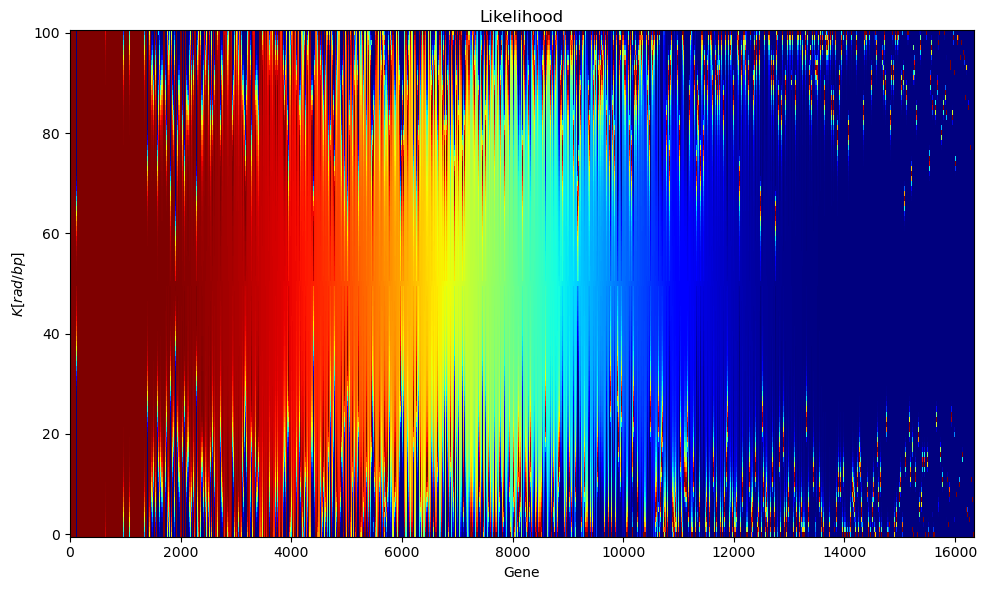

In [61]:


LL_ratio = LL.max(0) - LL[K==0,:] # log-likelihood ratio
idx_sort = np.argsort(LL_ratio)[0]


# plot log-likelihood

lik = np.exp(LL - LL.max(0))

fig, ax = plt.subplots(figsize=(10,6))
h = ax.imshow(lik[:,idx_sort],cmap='jet',origin='lower',aspect='auto',interpolation='none')
ax.set_xlabel('Gene')
ax.set_ylabel(r'$K [rad/bp]$')
ax.set_title('Likelihood')
#fig.colorbar(h, ax=ax)
fig.tight_layout()

#fig.savefig(out_ll_plot,bbox_inches='tight')


In [54]:
K_maxLL = np.zeros(LL.shape)
K_maxLL[np.argmax(LL,axis=0),np.arange(LL.shape[1])] = 1
count_K = K_maxLL.sum(1)
idx_neg = K<0
idx_pos = K>0
idx_zero = K==0

K_log = np.zeros(K.shape)
K_log[idx_neg] = -np.log10(-K[idx_neg])

K[K>0] = np.log10(K[K>0])

#K[np.argmax(LL,axis=0),:]


array([ 1.00000000e-04,  8.68511374e-05,  7.54312006e-05,  6.55128557e-05,
        5.68986603e-05,  4.94171336e-05,  4.29193426e-05,  3.72759372e-05,
        3.23745754e-05,  2.81176870e-05,  2.44205309e-05,  2.12095089e-05,
        1.84206997e-05,  1.59985872e-05,  1.38949549e-05,  1.20679264e-05,
        1.04811313e-05,  9.10298178e-06,  7.90604321e-06,  6.86648845e-06,
        5.96362332e-06,  5.17947468e-06,  4.49843267e-06,  3.90693994e-06,
        3.39322177e-06,  2.94705170e-06,  2.55954792e-06,  2.22299648e-06,
        1.93069773e-06,  1.67683294e-06,  1.45634848e-06,  1.26485522e-06,
        1.09854114e-06,  9.54095476e-07,  8.28642773e-07,  7.19685673e-07,
        6.25055193e-07,  5.42867544e-07,  4.71486636e-07,  4.09491506e-07,
        3.55648031e-07,  3.08884360e-07,  2.68269580e-07,  2.32995181e-07,
        2.02358965e-07,  1.75751062e-07,  1.52641797e-07,  1.32571137e-07,
        1.15139540e-07,  1.00000000e-07,  0.00000000e+00, -1.00000000e-07,
       -1.15139540e-07, -

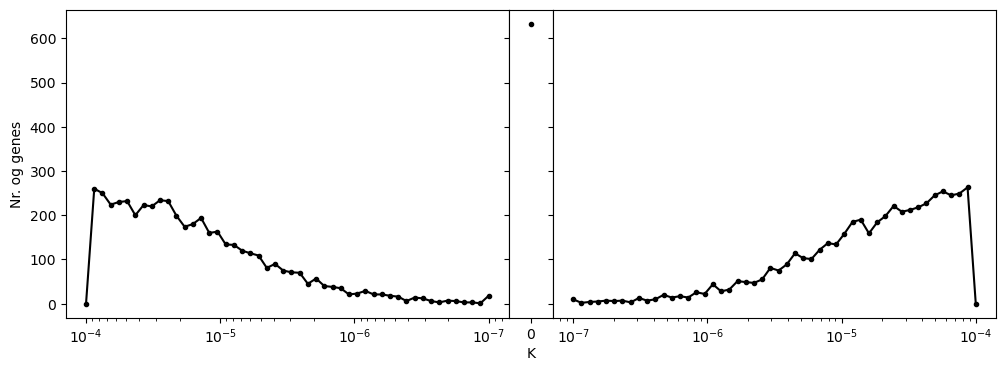

In [60]:

# create figure with 3 subplots sharing the same y-axis
fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(12, 4))

count_K[0] = 0
count_K[-1] = 0

# plot histogram of negative K_maxLL values
ax = axs[0]
ax.plot(-K[K<0], count_K[K<0],'k.-')
ax.invert_xaxis()
ax.set_ylabel('Nr. og genes')
ax.set_xscale('log')

# plot bar for K_maxLL = 0
ax = axs[1]
ax.plot(0, count_K[K==0],'k.')
ax.set_xlabel(r'K')
ax.set_xticks([0],['0'])

# plot histogram of positive K_maxLL values
ax = axs[2]
ax.plot(K[K>0], count_K[K>0],'k.-')
ax.set_xscale('log')



array([3.338e+03, 2.630e+02, 2.490e+02, 2.450e+02, 2.540e+02, 2.450e+02,
       2.270e+02, 2.180e+02, 2.120e+02, 2.080e+02, 2.210e+02, 1.980e+02,
       1.840e+02, 1.590e+02, 1.900e+02, 1.850e+02, 1.580e+02, 1.340e+02,
       1.370e+02, 1.220e+02, 1.010e+02, 1.030e+02, 1.140e+02, 8.900e+01,
       7.500e+01, 8.100e+01, 5.500e+01, 4.700e+01, 4.900e+01, 5.100e+01,
       3.200e+01, 2.800e+01, 4.400e+01, 2.200e+01, 2.600e+01, 1.400e+01,
       1.700e+01, 1.400e+01, 2.000e+01, 1.000e+01, 7.000e+00, 1.300e+01,
       3.000e+00, 7.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 4.000e+00,
       2.000e+00, 1.000e+01, 6.330e+02, 1.800e+01, 1.000e+00, 3.000e+00,
       3.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 6.000e+00, 1.200e+01,
       1.400e+01, 6.000e+00, 1.600e+01, 1.800e+01, 2.100e+01, 2.100e+01,
       2.900e+01, 2.300e+01, 2.100e+01, 3.500e+01, 3.800e+01, 4.000e+01,
       5.700e+01, 4.500e+01, 7.000e+01, 7.100e+01, 7.500e+01, 9.000e+01,
       8.100e+01, 1.090e+02, 1.140e+02, 1.200e+02, 

array([3.338e+03, 2.630e+02, 2.490e+02, 2.450e+02, 2.540e+02, 2.450e+02,
       2.270e+02, 2.180e+02, 2.120e+02, 2.080e+02, 2.210e+02, 1.980e+02,
       1.840e+02, 1.590e+02, 1.900e+02, 1.850e+02, 1.580e+02, 1.340e+02,
       1.370e+02, 1.220e+02, 1.010e+02, 1.030e+02, 1.140e+02, 8.900e+01,
       7.500e+01, 8.100e+01, 5.500e+01, 4.700e+01, 4.900e+01, 5.100e+01,
       3.200e+01, 2.800e+01, 4.400e+01, 2.200e+01, 2.600e+01, 1.400e+01,
       1.700e+01, 1.400e+01, 2.000e+01, 1.000e+01, 7.000e+00, 1.300e+01,
       3.000e+00, 7.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 4.000e+00,
       2.000e+00, 1.000e+01, 6.330e+02, 1.800e+01, 1.000e+00, 3.000e+00,
       3.000e+00, 6.000e+00, 7.000e+00, 3.000e+00, 6.000e+00, 1.200e+01,
       1.400e+01, 6.000e+00, 1.600e+01, 1.800e+01, 2.100e+01, 2.100e+01,
       2.900e+01, 2.300e+01, 2.100e+01, 3.500e+01, 3.800e+01, 4.000e+01,
       5.700e+01, 4.500e+01, 7.000e+01, 7.100e+01, 7.500e+01, 9.000e+01,
       8.100e+01, 1.090e+02, 1.140e+02, 1.200e+02, 